<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S10/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import cv2
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from skimage.feature import greycomatrix, greycoprops,local_binary_pattern
import torchvision.transforms.functional as TF

In [2]:


# Define the transformation to apply to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensor
])

# Download and load the CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Download and load the CIFAR10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:05<00:00, 28714181.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:


# Define the transformation to apply to the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image tensor
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3))  # Randomly erase a rectangle in the image
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

# Download and load the CIFAR10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


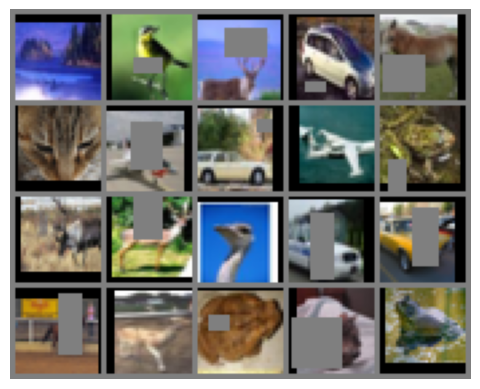

In [4]:

# Select a sample of 20 images from the training set
sample_indices = torch.randint(low=0, high=len(trainset), size=(20,))
sample_images = [trainset[i][0] for i in sample_indices]

# Create a grid of images
grid_image = torchvision.utils.make_grid(sample_images, nrow=5, padding=2)

# Unnormalize the grid_image tensor
grid_image = grid_image / 2 + 0.5

# Convert the tensor to numpy array
grid_image = grid_image.numpy().transpose((1, 2, 0))

# Display the grid of images
plt.imshow(grid_image)
plt.axis('off')
plt.show()

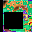

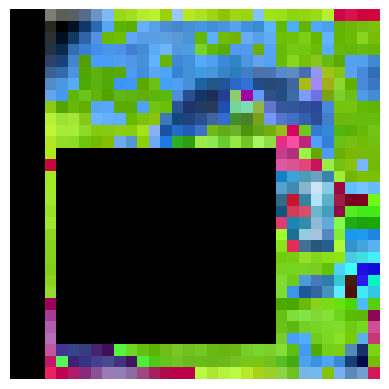

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


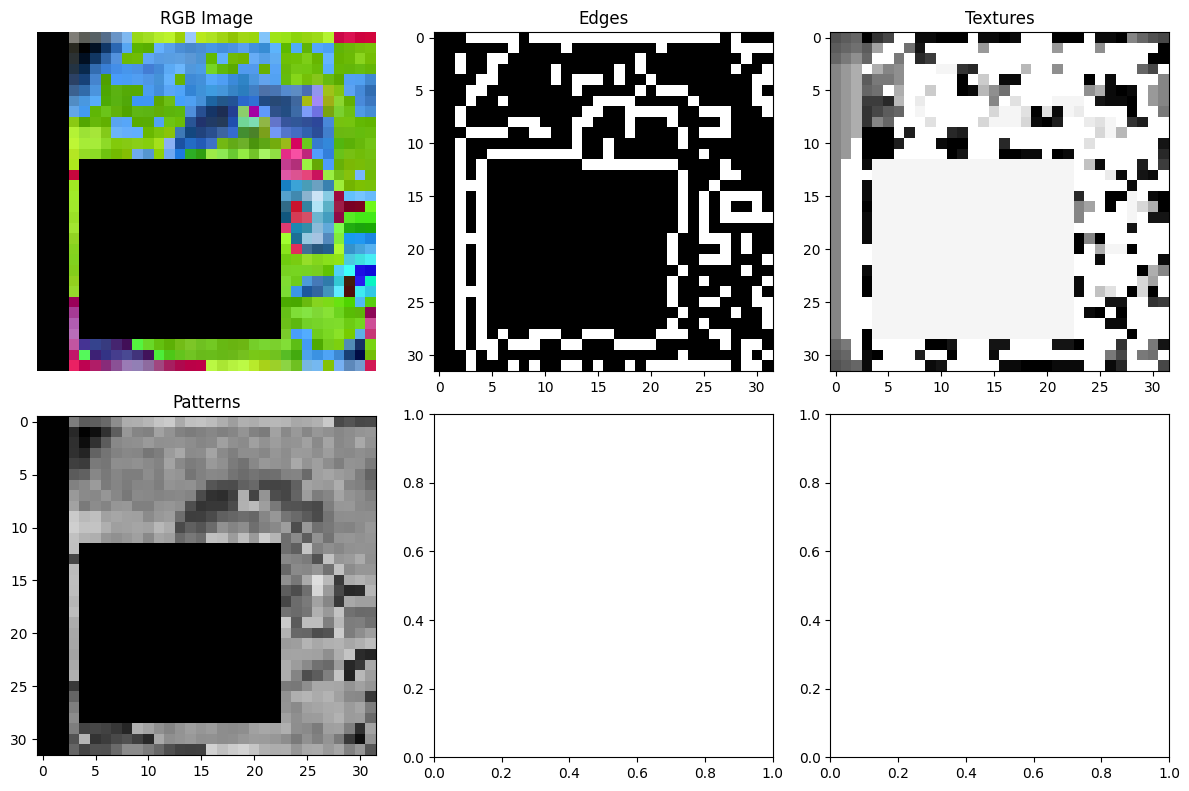

In [34]:
# Select an image from the training set
image_index = 0  # Change this to the desired image index
image, label = trainset[image_index]


# Convert the tensor image to a PIL image
pil_image = TF.to_pil_image(image)

# Display the PIL image
pil_image.show()


# # Convert the tensor image to numpy array
# image = image.numpy().transpose((1, 2, 0))

# # Convert the image to RGB format
# image_rgb = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2RGB)

# # Display the image
# plt.imshow(image_rgb)
# plt.axis('off')  # Optional: Hide axis ticks
# plt.show()


# Apply edge detection using Canny edge detection algorithm
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(image_gray, threshold1=30, threshold2=100)

# Apply unsharp masking to enhance details
blur = cv2.GaussianBlur(image_gray, (0, 0), sigmaX=2)
sharp = cv2.addWeighted(image_gray, 1.5, blur, -0.5, 0)

# Apply texture analysis using Local Binary Patterns (LBP)
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(image_gray, n_points, radius, method='uniform')

# Apply contrast stretching to enhance the image's dynamic range
min_val = np.min(sharp)
max_val = np.max(sharp)
stretch = cv2.convertScaleAbs(sharp, alpha=255.0/(max_val-min_val), beta=-min_val * 255.0 / (max_val-min_val))

# Perform pattern detection using Oriented FAST and Rotated BRIEF (ORB)
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(image_gray, None)

# Compute gray-level co-occurrence matrix for texture analysis
image_texture = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
co_matrix = greycomatrix(image_texture, distances=[1], angles=[0], symmetric=True, normed=True)
contrast = greycoprops(co_matrix, prop='contrast')[0, 0]
dissimilarity = greycoprops(co_matrix, prop='dissimilarity')[0, 0]
homogeneity = greycoprops(co_matrix, prop='homogeneity')[0, 0]

# Display the original image, edges, textures, patterns, and detected objects
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title('Edges')

axes[0, 2].imshow(lbp, cmap='gray')
axes[0, 2].set_title('Textures')

axes[1, 0].imshow(cv2.drawKeypoints(image_gray, keypoints, None))
axes[1, 0].set_title('Patterns')

axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

# axes[0, 1].imshow(edges, cmap='gray')
# axes[0, 1].set_title('Edges')
# axes[0, 1].axis('off')



plt.tight_layout()
plt.show()

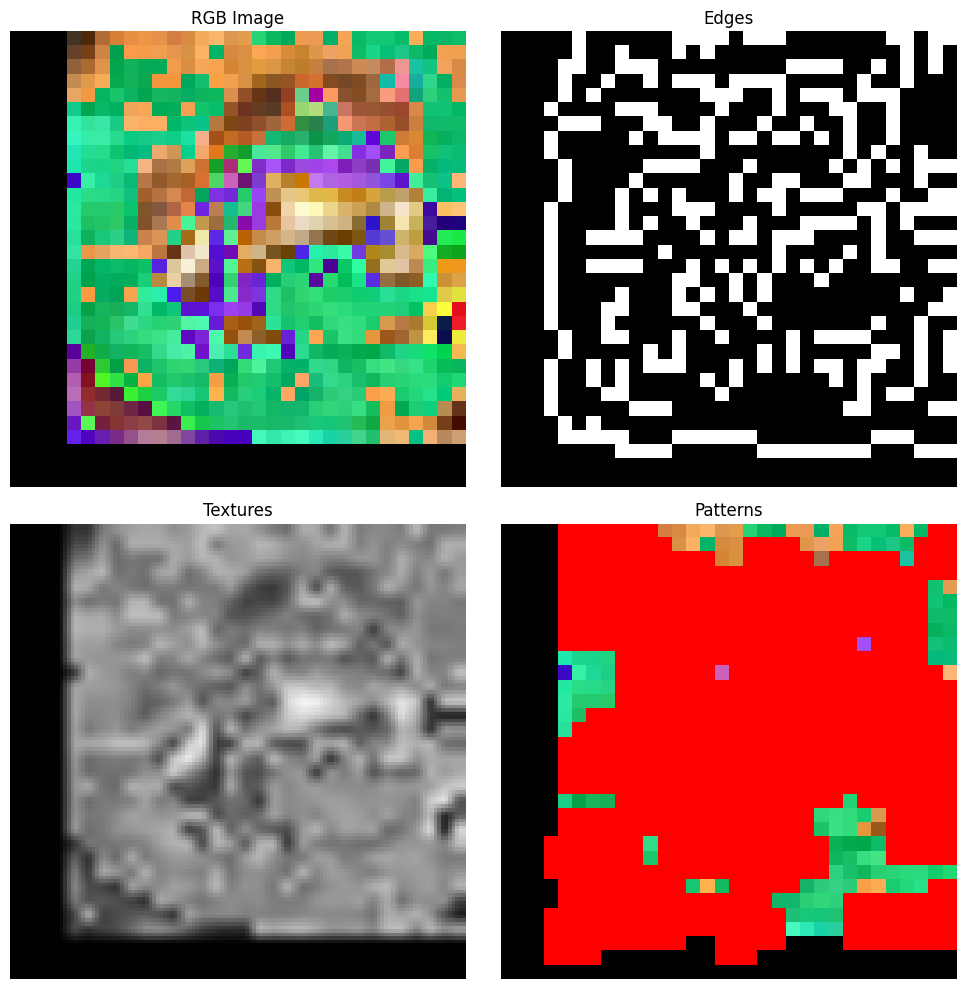

In [35]:
# Select an image from the training set
image_index = 0  # Change this to choose a different image
image, _ = trainset[image_index]

# Convert the image tensor to a numpy array and transpose the dimensions
image = image.numpy().transpose((1, 2, 0))

# Convert the image from tensor range [0, 1] to [0, 255]
image = (image * 255).astype('uint8')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 200)

# Apply texture analysis using the Haralick method
textures = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
textures = cv2.resize(textures, (128, 128))  # Resize for better visualization
textures = cv2.cvtColor(textures, cv2.COLOR_GRAY2RGB)

# Apply pattern detection using Harris corner detection
corners = cv2.cornerHarris(gray, 2, 3, 0.04)
corners = cv2.dilate(corners, None)  # Enhance corners for better visualization
patterns = image.copy()
patterns[corners > 0.01 * corners.max()] = [255, 0, 0]


# Display the original image, edges, textures, and patterns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges, cmap='gray')
axes[0, 1].set_title('Edges')
axes[0, 1].axis('off')

axes[1, 0].imshow(textures)
axes[1, 0].set_title('Textures')
axes[1, 0].axis('off')

axes[1, 1].imshow(patterns)
axes[1, 1].set_title('Patterns')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [36]:


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return x + self.residual(x)

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.prep_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResBlock(128, 128)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            ResBlock(512, 512)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=4)

        self.fc = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.prep_layer(x)
        x = self.layer1(x)
        x = x + self.layer1[3](x)  # Skip connection
        x = self.layer2(x)
        x = self.layer3(x)
        x = x + self.layer3[4](x)  # Skip connection
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Creating an instance of the CustomResNet model
model = CustomResNet()


In [37]:


model = CustomResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluating the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch [1/20], Loss: 2.1324
Epoch [2/20], Loss: 2.0250
Epoch [3/20], Loss: 1.9707
Epoch [4/20], Loss: 1.9394
Epoch [5/20], Loss: 1.9114
Epoch [6/20], Loss: 1.8878
Epoch [7/20], Loss: 1.8691
Epoch [8/20], Loss: 1.8529
Epoch [9/20], Loss: 1.8431
Epoch [10/20], Loss: 1.8356
Epoch [11/20], Loss: 1.8283
Epoch [12/20], Loss: 1.8214
Epoch [13/20], Loss: 1.8106
Epoch [14/20], Loss: 1.8080
Epoch [15/20], Loss: 1.8066
Epoch [16/20], Loss: 1.8020
Epoch [17/20], Loss: 1.7987
Epoch [18/20], Loss: 1.7931
Epoch [19/20], Loss: 1.7901
Epoch [20/20], Loss: 1.7852
Test Accuracy: 67.66%
